In [1]:
#@title Imports
import requests, os, zipfile
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional

import copy
from collections import namedtuple
import random
import shutil
import time
# Path to the events archive
dataset_zip = '/tmp/glaucoma.zip'

# Path to the extracted events
dataset_dir = '/tmp/dataset/'

# Path to the dataset file
dataset_pkl = '/tmp/dataset.zip'

# Path to the model
model_path = '/tmp/'

In [2]:
#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download the dataset combined
#download_file_from_google_drive('1XbECYqiqKzlBOsd7DfhK9LwXV1rSmNUD', dataset_zip)
download_file_from_google_drive('1Nz0WQToBpYTv2j4xWxF5YNonMmRQ2vok', dataset_zip)
# Unzip the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [3]:
#@title Dataset paths
# Paths to event files
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [4]:
#@title Print Dataset Statistics


train_images = glob.glob(os.path.join(train_dir,'*', '*.jpg'))
validation_images = glob.glob(os.path.join(validation_dir,'*', '*.jpg'))
test_images = glob.glob(os.path.join(test_dir,'*', '*.jpg'))

train_classes = [os.path.basename(os.path.dirname(x)) for x in train_images]
validation_classes = [os.path.basename(os.path.dirname(x)) for x in validation_images]
test_classes = [os.path.basename(os.path.dirname(x)) for x in test_images]

assert len(set(train_classes))==len(set(validation_classes)), 'Class mismatch between train and val'
classes = set(train_classes)
num_classes = len(classes)

for class_ in classes:
  print('Class {}: training images: {}, test images: {}, validation images: {}'.format(class_, train_classes.count(class_), test_classes.count(class_), validation_classes.count(class_)))
print('\nTotal training images:', len(train_images))
print('Total test images:', len(test_images))
print('Total validation images:', len(validation_images))

print('Number of classes:', num_classes)

Class GL: training images: 1486, test images: 188, validation images: 185
Class HE: training images: 2650, test images: 333, validation images: 330

Total training images: 4136
Total test images: 521
Total validation images: 515
Number of classes: 2


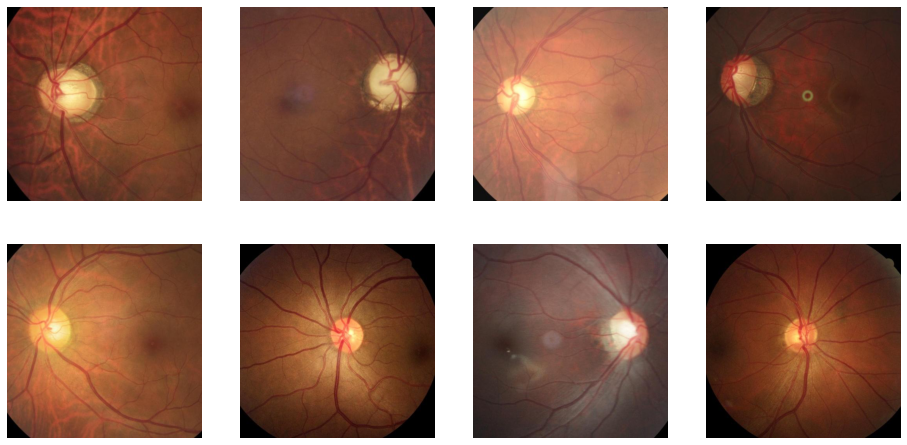

In [5]:
#@title Plot images
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = num_classes
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for row, class_ in enumerate(classes):
  class_images = [img for img,label in zip(validation_images, validation_classes) if label==class_]
  for col in range(ncols):
    sp = plt.subplot(nrows, ncols, row*ncols+col+1)
    sp.axis('Off')
    img = mpimg.imread(class_images[col])
    plt.imshow(img)
    
plt.show()

In [6]:
#@title Define transforms for the training, validation, and testing sets
pretrained_size = 224
pretrained_means =  [0.4894, 0.2924, 0.1910] #[0.485, 0.456, 0.406]
pretrained_stds= [0.1567, 0.1097, 0.0697] #[0.229, 0.224, 0.225]

training_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

testing_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

validation_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
BATCH_SIZE = 128
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE)

In [7]:
#@title Model Class
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
    ) -> None:
        super(Bottleneck, self).__init__()

        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)

        self.conv2 = conv3x3(width, width, stride, groups, dilation)

        self.conv3 = conv1x1(width, planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)

        out = self.relu(out)

        out = self.conv2(out)

        out = self.relu(out)

        out = self.conv3(out)


        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 2,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()


        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677


    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                ))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)

        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model

def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [8]:
#@title Accuracy calculation function
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy



In [9]:
#@title Hyperparameters and model print
EPOCHS = 60
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
device = torch.device("cuda")
OUTPUT_DIM = len(testing_dataset.classes)
model = resnet50()
LR = 1e-3
fc =  nn.Linear(2048, OUTPUT_DIM)
# fc = nn.Sequential(
#     nn.Dropout(0.33),
#     nn.Linear(2048, OUTPUT_DIM)
# )
model.fc = fc

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (co

In [10]:
#@title Train
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for x, y in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()

        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [11]:
#@title Evaluation function
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
train_accu = []
train_losses = []
eval_losses=[]
eval_accu=[]

In [ ]:
#@title Training
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, test_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_accu.append(train_acc_1)
    train_losses.append(train_loss)
    eval_losses.append(valid_loss)
    eval_accu.append(valid_acc_1)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 1m 3s
	Train Loss: 36.021 | Train Acc @1:  61.47%
	Valid Loss: 0.678 | Valid Acc @1:  52.81%
Epoch: 02 | Epoch Time: 1m 2s
	Train Loss: 0.609 | Train Acc @1:  66.96%
	Valid Loss: 0.572 | Valid Acc @1:  77.97%
Epoch: 03 | Epoch Time: 1m 3s
	Train Loss: 0.613 | Train Acc @1:  67.23%
	Valid Loss: 0.601 | Valid Acc @1:  77.81%
Epoch: 04 | Epoch Time: 1m 3s
	Train Loss: 0.513 | Train Acc @1:  76.44%
	Valid Loss: 0.461 | Valid Acc @1:  81.41%
Epoch: 05 | Epoch Time: 1m 3s
	Train Loss: 0.524 | Train Acc @1:  74.71%
	Valid Loss: 0.483 | Valid Acc @1:  82.19%
Epoch: 06 | Epoch Time: 1m 3s
	Train Loss: 0.436 | Train Acc @1:  79.87%
	Valid Loss: 0.507 | Valid Acc @1:  82.19%
Epoch: 07 | Epoch Time: 1m 3s
	Train Loss: 0.404 | Train Acc @1:  81.44%
	Valid Loss: 0.597 | Valid Acc @1:  68.00%
Epoch: 08 | Epoch Time: 1m 4s
	Train Loss: 0.379 | Train Acc @1:  83.27%
	Valid Loss: 0.480 | Valid Acc @1:  72.76%
Epoch: 09 | Epoch Time: 1m 3s
	Train Loss: 0.360 | Train Acc @1:  83.59

In [ ]:
#@title Plot Train vs Valid Accuracy
plt.plot(train_accu,'-')
plt.plot(eval_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

In [ ]:
#@title Plot Train vs Valid Losses
plt.plot(train_losses[1:],'-')
plt.plot(eval_losses[1:],'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels, normalize='true')
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot( cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

In [ ]:
images, labels, probs = get_predictions(model, validate_loader)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
accuracy_score(labels, pred_labels)

In [ ]:
model_folder = glob.glob(os.path.join(model_path))
torch.save(model.state_dict(), model_folder[0]+"baseline_model_60_epochs.pt")
